In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os import path

from IPython.display import clear_output
from tqdm import tqdm
from time import time

import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn
from torch.functional import F

In [4]:
from torchvision.models import vgg
from torchvision.datasets.folder import default_loader as image_loader
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.set_device(1)

In [7]:
from agereg import pad_to_square, load_module, save_module, split_array
from agereg import ImageAgeDataset
from agereg import RMSELoss, AgeRegModel, make_layers_old, ConstDropout
from agereg import compute_loss_with_l2, compute_loss_with_l1

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 2e-5
SPLITS = [0.5, 0.05, 0.05, 0.4] # TRAIN, TEST, VAL, POOL
# DATASET = 'AgeDB' 
DATASET = 'UTKFace' 
assert sum(SPLITS) == 1

### MODEL 

In [10]:
features = vgg.make_layers(vgg.cfgs['D'])
features = load_module(features, 'vgg-features.pt')
features.add_module('31', nn.AdaptiveAvgPool2d(output_size=(7, 7)))
# features.add_module('31', nn.AdaptiveMaxPool2d(output_size=(3, 3)))


In [11]:
# class features_avg_max(nn.Module):
#     def __init__(self, features, k_size=2):
#         super().__init__()
        
#         self.maxpool = nn.AdaptiveMaxPool2d(output_size=(k_size, k_size))
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(k_size, k_size))
#         self.features = features
    
#     def forward(self, x):
#         x = self.features(x)
#         x_max = self.maxpool(x)
#         x_max = x_max.view(x_max.size(0), -1)
#         x_avg = self.avgpool(x)
#         x_avg = x_avg.view(x_max.size(0), -1)
#         return torch.cat([x_max, x_avg], dim=1)

In [12]:
# features =  features_avg_max(features_vgg)

In [13]:
def print_net_params(net):
    train_p = sum(map(lambda x: np.prod(x.size()), filter(lambda p: p.requires_grad, net.parameters())))
    nontr_p = sum(map(lambda x: np.prod(x.size()), filter(lambda p: not p.requires_grad, net.parameters())))
    
    print('-'*10)
    print('Trainable parameters:    \t{}'.format(train_p))    
    print('Nontrainable parameters: \t{}'.format(nontr_p))
    print('All parameters:          \t{}'.format(train_p + nontr_p))

In [14]:
print_net_params(features)

----------
Trainable parameters:    	14714688
Nontrainable parameters: 	0
All parameters:          	14714688


In [15]:
def find_num(seq):
    for i in seq:
        if isinstance(i, int):
            return i
    return False

def make_layers(stm, default_p=0.5, default_neg_slope=0.1):    
    
    layers = []
    num_in=stm[0]
    stm = stm[1:]

    for l in stm:
        if isinstance(l, str):
            if l == 'LR':
                if len(l) == 2:
                    neg_s = default_neg_slope
                else:
                    neg_s = float(l[2:])
                layers += [nn.LeakyReLU(negative_slope=neg_s, inplace=True)]
            if l == 'R':
                layers += [nn.ReLU(inplace=True)]
            if l == 'S':
                layers += [nn.Sigmoid()]
            if l[0] == 'D':
                if len(l) == 1:
                    p = default_p
                else:
                    p = float(l[1:])
#                 layers += [ConstDropout(num_in, p=p)]
                layers += [nn.Dropout(p=p)]
            if l == 'B':
                layers += [nn.BatchNorm1d(num_in)]
        if isinstance(l, int):
            layers += [nn.Linear(num_in, l)]
            num_in = l
    
    return nn.Sequential(*layers)

In [16]:
models = {
    'mark0':   [7*7*512, 512, 'LR', 256, 'LR', 64, 'R', 1],
    'mark1':   [7*7*512, 512, 'LR', 'D.3', 256, 'LR', 'D.3', 64, 'LR', 1],
    'mark1.1': [7*7*512, 1024, 'LR', 'D.4', 512, 'LR', 'D.4', 128, 'R', 1],
    'mark2':   [7*7*512, 512, 'LR', 'B','D', 256, 'LR', 'B','D', 64, 'R', 1],
    'mark2.1': [7*7*512, 1024, 'LR', 'B','D.4', 512, 'LR', 'B','D.4', 100, 'LR', 1],
    'mark3':   [7*7*512, 4096, 'LR', 'D.3', 4096, 'LR', 'D.3', 1024, 'R', 1],
    'mark4':   [7*7*512, 'D.1', 4096, 'LR', 'B','D.3', 4096, 'LR', 'B','D.3', 1024, 'R', 1],
    'mark5':   [5*5*512, 512, 'LR', 'B','D.2', 512, 'LR', 'B','D.3', 128, 'R', 1],
    'mark6':   [3*3*512, 512, 'LR', 'B','D.4', 512, 'LR','D.4', 128, 'R', 1],
    'mark7':   [2*2*2*512, 512, 'LR', 'B','D.4', 512, 'LR','D.4', 128, 'R', 1],
    'mark8':   [2*2*2*512, 1024, 'LR', 'D.4', 512, 'LR','D.4', 128, 'R', 1],
    'mark9':   [7*7*512, 'D.3', 1024, 'LR', 'D.3', 256, 'LR', 1]
}

In [17]:
regression = make_layers(models['mark9'])

In [18]:
print_net_params(regression)

----------
Trainable parameters:    	25953793
Nontrainable parameters: 	0
All parameters:          	25953793


In [19]:
model = AgeRegModel(features, regression)
criterion = RMSELoss()

In [20]:
model

AgeRegModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17)

In [21]:
print_net_params(model)

----------
Trainable parameters:    	25953793
Nontrainable parameters: 	14714688
All parameters:          	40668481


### Images

In [22]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(pad_to_square),
        transforms.Resize((224, 224), interpolation=1),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(degrees=15),
#         transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomAffine(15, (0.02,) * 2, shear=1, fillcolor=(0,) * 3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#         transforms_black_box
    ]),
    'pool': transforms.Compose([
        transforms.Lambda(pad_to_square),
        transforms.Resize((224, 224), interpolation=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Lambda(pad_to_square),
        transforms.Resize((224, 224), interpolation=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Lambda(pad_to_square),
        transforms.Resize((224, 224), interpolation=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

In [23]:

if DATASET == 'AgeDB':
    folders = ['/home/mokrov/agereg/data/AgeDB']
    get_age = lambda file: int(file.split('_')[-2])
elif DATASET == 'UTKFace':
    folders = ['/home/mokrov/agereg/data/UTKFace/']
    get_age = lambda file: int(file.split('/')[-1].split('_')[0])
else:
    assert False, 'Unknown dataset name'
    
files = [path.join(p, i) for p in folders for i in os.listdir(p)]
split_files = split_array(files, SPLITS, seed=42)

datasets = {key: ImageAgeDataset(arr, image_transforms[key], get_age)
            for arr, key in zip(split_files, ['train', 'test', 'val', 'pool'])}

In [24]:
dataloaders = {key: DataLoader(val, batch_size = BATCH_SIZE, shuffle= (key == 'train'))
               for key, val in datasets.items()}

In [25]:
for key in datasets.keys():
    print('{} len:\t{}'.format(key.upper(), datasets[key].__len__()))

TRAIN len:	11854
TEST len:	1185
VAL len:	1185
POOL len:	9484


In [26]:
castom_transforms = transforms.Compose([
        transforms.Lambda(pad_to_square),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue=.1, saturation=.1),
        transforms.RandomAffine(15, (0.05,) * 2, shear=5, fillcolor=(0,) * 3),
        transforms.Resize((224, 224), interpolation=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        
    ])

In [27]:
file = np.random.choice(files)

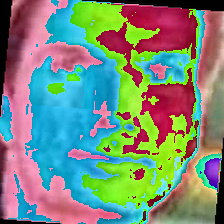

In [28]:
tns = castom_transforms(image_loader(file))
# tns_norm = (tns - 0.5)/np.sqrt(0.5)
# tns_norm = transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])(tns)
img = transforms.ToPILImage()(tns)
img

In [29]:
tns.min(), tns.max(), tns.mean()

(tensor(-1.), tensor(0.9686), tensor(-0.1415))

In [30]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion.cuda()

In [31]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error as max_ae

def rmse(y1, y2):
    return np.sqrt(mse(y1, y2))

def get_errors(y1, y2):
    return rmse(y1, y2), mae(y1, y2)

In [32]:
def train_single_epoch_model(model, criterion,
                             dataloader, optimizer,
                             use_gpu=torch.cuda.is_available()):
    model = model.train(True)
    running_loss = .0
    y_true = []
    y_pred = []
    for inputs, ys in tqdm(dataloader, desc='Training model',
                           unit_scale=dataloader.batch_size):
        if use_gpu:
            inputs = inputs.cuda()
            ys = ys.cuda()
    
        optimizer.zero_grad()
        outputs = model(inputs)   
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()
        #stat
        y_true.append(ys.cpu().data.numpy())
        y_pred.append(outputs.cpu().data.numpy())
            
        running_loss += loss.item() * len(ys)
    
    with torch.autograd.no_grad():
        n_samples = dataloader.dataset.__len__()
        _loss = running_loss / n_samples
        errors = get_errors(np.concatenate(y_true), np.concatenate(y_pred))
        return _loss, errors 

In [33]:
def test_model(model, dataloader, use_gpu=torch.cuda.is_available()):
    with torch.autograd.no_grad():
        model = model.train(False)
        y_true = []
        y_pred = []
        for inputs, ys in tqdm(dataloader, desc='Testing model',
                           unit_scale=dataloader.batch_size):
            if use_gpu:
                inputs = inputs.cuda()
                ys = ys.cuda()
            outputs = model(inputs)
            y_true.append(ys.cpu().data.numpy())
            y_pred.append(outputs.cpu().data.numpy())
            
        errors = get_errors(np.concatenate(y_true), np.concatenate(y_pred))
        return errors

In [34]:
def print_statistics(logs, n_epochs, patience_max):
    print('Train Epoch #{} out of {}.'.format(logs['epochs'], n_epochs), flush=True)
    if logs['epochs'] > 0:     
        print('Loss:   {:.2f}'.format(logs['train_loss'][-1]), flush=True)
        print('                  | RMSE | MAE  |', flush=True)
        print('Last train stats: | {:.2f} | {:.2f} |'.format(
            logs['train_errors'][-1][0],
            logs['train_errors'][-1][1]), flush=True)
    if logs['epochs'] >= logs['check_every']:         
        print('Last val stats:   | {:.2f} | {:.2f} |'.format(
            logs['val_errors'][-1][0],
            logs['val_errors'][-1][1]), flush=True)
    
    print('Patience: {}/{}'.format(logs['patience'], patience_max), flush=True)
    print('Learning rate: {:.8f}'.format(logs['lr'][0]), flush=True)

In [35]:
def train_model(model, criterion, dataloaders,
                n_epochs, check_every, patience_max=10,
                lr_init = LEARNING_RATE, lr_decay_epoch=50, lr_gamma=0.1, lr_min=1e-5,
                use_gpu=torch.cuda.is_available()):
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=lr_init, weight_decay=WEIGHT_DECAY)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr_init, weight_decay=WEIGHT_DECAY)
    scheduler = lr_scheduler.StepLR(optimizer, lr_decay_epoch, lr_gamma)
    
    if n_epochs % check_every:
        n_epochs += check_every - n_epochs % check_every
    current_error = 1e+10
    logs = {'train_loss': list(),
            'train_errors': list(),
            'val_errors': list(),
            'check_every': check_every,
            'epochs': 0,
            'patience': 0,
            'lr': 0}
    started_at = time()
    try:
        for epoch in range(n_epochs):
            ##############################################################################
            #                           STATISTICS                                       #
            ##############################################################################
            logs['lr'] = scheduler.get_lr()
            if logs['lr'][0] > lr_min:
                scheduler.step()
            clear_output(True)
            print_statistics(logs, n_epochs, patience_max)
            ##############################################################################
            #                             TRAINING                                       #
            ##############################################################################
            train_loss, train_errors = train_single_epoch_model(model, criterion,
                                                                dataloaders['train'],
                                                                optimizer, use_gpu=use_gpu)
            logs['train_errors'] += [train_errors]
            logs['train_loss'] += [train_loss]
            logs['epochs'] = epoch + 1
            ##############################################################################
            #                              ERRORS                                        #
            ##############################################################################
            if ((epoch + 1) % check_every == 0):
                val_errors = test_model(model, dataloaders['val'])
                logs['val_errors'] += [val_errors]
                logs['epochs'] = epoch + 1
                if val_errors[0] > current_error:
                    logs['patience'] += 1
                current_error = val_errors[0]
                if logs['patience'] > patience_max:
                    print('Early stopping in epoch {}'.format(epoch + 1))
                    break
                
            ##############################################################################
            #                   END ONE EPOCH  --- REPEAT                                #
            ##############################################################################
    except KeyboardInterrupt:
        print('Interrupted!')
        epoch = epoch - 1
#     clear_output(True)
    total_time = time() - started_at
    logs['time'] = total_time
    logs['epochs'] = epoch + 1
    print('-' * 20)
    print('Training complete in {:.0f} mins {:.0f} seconds with {} epochs'.format(total_time // 60,
                                                                                  total_time % 60,
                                                                                  epoch+1), flush=True)
    
    try:
        ##############################################################################
        #                                TEST                                        #
        ##############################################################################
        test_errors = test_model(model, dataloaders['test'])
        logs['test'] = test_errors
    except KeyboardInterrupt:
        print('Interrupted!')
    return model, logs

In [36]:
def plot_logs(logs):
    f, ax = plt.subplots(1, 2, figsize=(16, 5))

    x_train = np.arange(logs['epochs'])
    y_train = np.arange(logs['check_every'], logs['epochs']+1, logs['check_every'])
    # plt.plot(x_train, logs['train_loss'], label='loss')

    ax[0].plot(x_train, np.array(logs['train_errors'])[:, 0], label='train')
    ax[0].plot(y_train, np.array(logs['val_errors'])[:, 0], label='test')
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title('RMSE')

    ax[1].plot(x_train, np.array(logs['train_errors'])[:, 1], label='train')
    ax[1].plot(y_train, np.array(logs['val_errors'])[:, 1], label='test')
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title('MAE')

    plt.show()

In [37]:
params = {
    'model': model,
    'criterion': criterion,
    'dataloaders': dataloaders,
    'n_epochs': 300,
    'check_every': 5,
    'patience_max': 30,
    'lr_init': 5e-3,
    'lr_gamma': 0.1, 
    'lr_decay_epoch': 75,
    'lr_min': 5e-6,
}



model, logs = train_model(**params)

Train Epoch #277 out of 300.
Loss:   9.40
                  | RMSE | MAE  |
Last train stats: | 9.49 | 6.81 |
Last val stats:   | 9.12 | 6.44 |
Patience: 30/30
Learning rate: 0.00000500


Training model:   0%|          | 0/11904 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



UtkFace


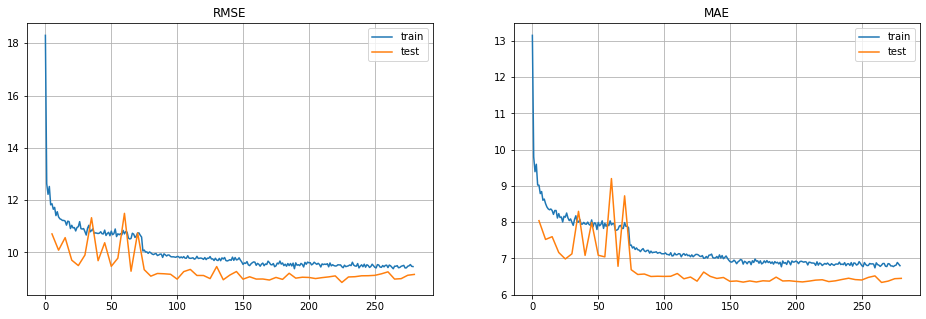

In [38]:
print('UtkFace')
plot_logs(logs)

In [39]:
logs['test']

(9.163978, 6.2664695)

In [40]:
save_module(model.regression, 'reg-mark9-utkface.pt')

AgeDB


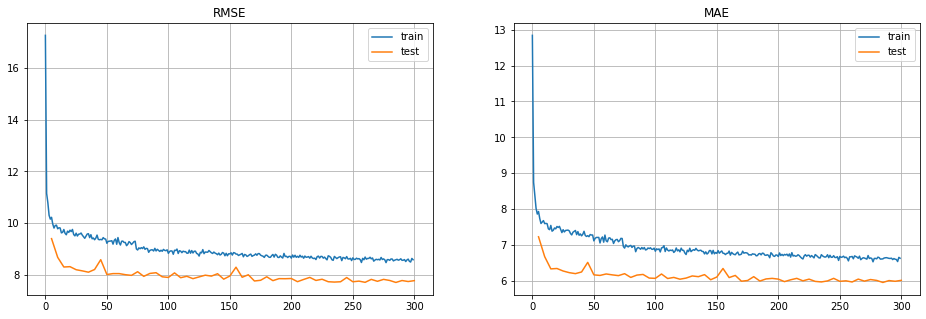

In [83]:
print('AgeDB')
plot_logs(logs)

In [80]:
logs['test']

(8.364963, 6.479772)

In [84]:
save_module(model.regression, 'reg-mark9-agedb.pt')

In [82]:
test_model(model, dataloaders['pool'])

Testing model: 100%|██████████| 6656/6656 [00:35<00:00, 185.24it/s]


(8.589898, 6.614425)

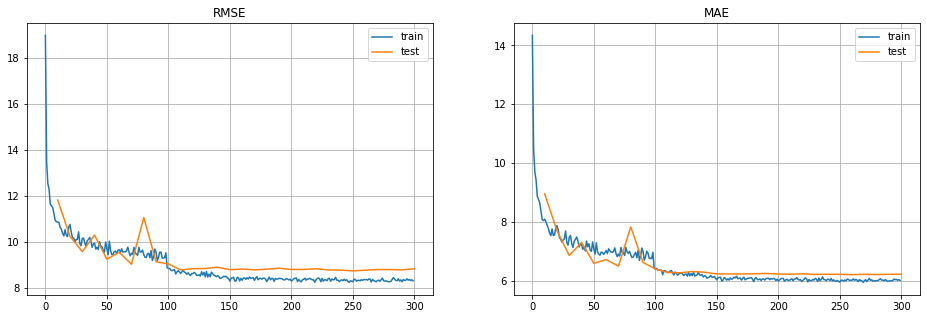

In [35]:
#mark 2

f, ax = plt.subplots(1, 2, figsize=(16, 5))

x_train = np.arange(logs['epochs'])
y_train = np.arange(logs['check_every'], logs['epochs']+1, logs['check_every'])
# plt.plot(x_train, logs['train_loss'], label='loss')

ax[0].plot(x_train, np.array(logs['train_errors'])[:, 0], label='train')
ax[0].plot(y_train, np.array(logs['val_errors'])[:, 0], label='test')
ax[0].grid()
ax[0].legend()
ax[0].set_title('RMSE')

ax[1].plot(x_train, np.array(logs['train_errors'])[:, 1], label='train')
ax[1].plot(y_train, np.array(logs['val_errors'])[:, 1], label='test')
ax[1].grid()
ax[1].legend()
ax[1].set_title('MAE')

plt.show()

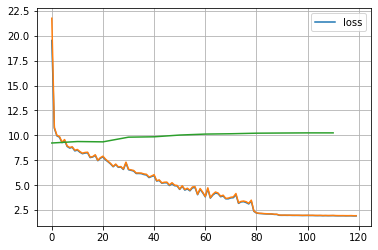

In [36]:
#mark 0
plt.plot(np.arange(logs['epochs']) , logs['train_loss'], label='loss')
plt.plot(np.arange(logs['epochs']), np.array(logs['train_errors'])[:, 0])
plt.plot(np.arange(0, logs['epochs'], logs['check_every']), np.array(logs['val_errors'])[:, 0])

# plt.semilogy()
plt.grid()
plt.legend()
plt.show()

In [41]:
def uncertancy_estimation(model, dataloader, num_rep = 10, p=0.5, print_const = '', use_gpu=torch.cuda.is_available()):
    with torch.autograd.no_grad():
        samples = []
        for i in range(num_rep):
            res = []
            clear_output(True)
            print(print_const)
            print('Repetition {} out of {}'.format(i+1, num_rep), flush=True)
            model.freeze_mask_dropout(new_p = p)
            for inputs, ys in tqdm(dataloader, desc='UE etimating',
                                   unit_scale=dataloader.batch_size):
                if use_gpu:
                    inputs = inputs.cuda()
                outputs = model(inputs)
                res.append(np.array(outputs.cpu()))
            samples.append(np.concatenate(res))
            model.unfreeze_mask_dropout()
        unc_est = np.std(samples, axis=0)
        return unc_est

In [42]:
def ae_estimation(model, dataloader, use_gpu=torch.cuda.is_available()):
    with torch.autograd.no_grad():
        model = model.train(False)
        y_true = []
        y_pred = []
        for inputs, ys in tqdm(dataloader, desc='Testing model',
                           unit_scale=dataloader.batch_size):
            if use_gpu:
                inputs = inputs.cuda()
                ys = ys.cuda()
            outputs = model(inputs)
            y_true.append(np.array(ys.cpu()))
            y_pred.append(np.array(outputs.cpu()))
            
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        ae = abs(y_true - y_pred)
        return ae, y_true, y_pred

In [43]:
k = 500

In [44]:
def get_max_k_ind(x, k = 100):
    return x.argsort()[::-1][:k]

In [45]:
def precision_k(y_true, y_pred, k=None):
    if k is None:
        k = len(y_true)
    
    order = np.argsort(y_true)[::-1]
    y_true = np.take(y_true, order[:k])
    
    precision = len(set(y_true) & set(y_pred)) / k
    return precision

def average_precision(y_true, y_pred):
    return np.mean([precision_k(y_true, y_pred, k=ki)
                    for ki in range(1, k+1)])

In [46]:
model = model.cuda()

In [47]:
ae, y_true, y_pred = ae_estimation(model, dataloaders['pool'])
true_ind = get_max_k_ind(ae.ravel())

Testing model: 100%|██████████| 9536/9536 [00:45<00:00, 211.20it/s]


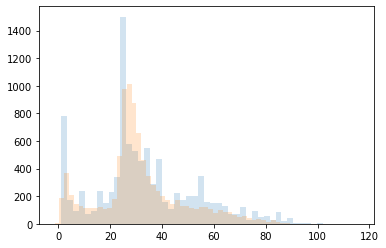

In [48]:
plt.hist(y_true, bins=50, alpha=0.2)
plt.hist(y_pred, bins=50, alpha=0.2)
plt.show()

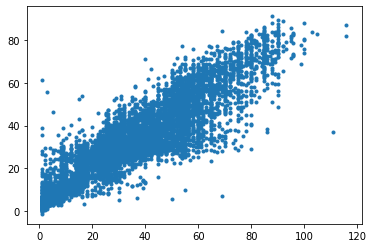

In [49]:
plt.plot(y_true, y_pred, '.')
plt.show()

In [55]:
np.array(split_files[3])[true_ind[:10]]

array(['/home/mokrov/agereg/data/UTKFace/111_1_0_20170120134646399.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/69_1_0_20170110131708449.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/1_1_0_20170109194452834.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/3_0_0_20170110212752045.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/80_0_2_20170111210646563.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/86_1_2_20170105174652949.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/86_1_2_20170110132518353.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/75_0_0_20170117174808021.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/76_1_2_20170112205409556.jpg.chip.jpg',
       '/home/mokrov/agereg/data/UTKFace/55_1_3_20170119171332121.jpg.chip.jpg'],
      dtype='<U71')

/home/mokrov/agereg/data/UTKFace/5_1_0_20170104202352685.jpg.chip.jpg
LABEL: 5
PREDICT: 46.317028


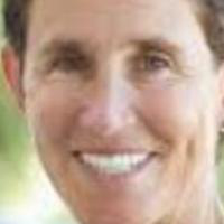

In [72]:
i = true_ind[15]
print(split_files[3][i])
tns = image_transforms['val'](image_loader(split_files[3][i]))
print('LABEL:', get_age(split_files[3][i]))
print('PREDICT:', model.cpu()(tns[None, :, :, :]).data.numpy()[0, 0])
image_loader(split_files[3][i]).resize((224, 224))

In [ ]:
ue = uncertancy_estimation(model, dataloaders['pool'], num_rep=5, p=0.5)

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(ue, ae, '.', alpha=0.1)
# plt.ylim([-1, 50])

In [ ]:
plt.hist(ue[ue < 20], bins=50)
plt.show()

In [ ]:
res = []
ps = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for pi in ps:
    clear_output(True)
    print('{}/10'.format(round(pi * 10)), flush=True)
    unc_est = uncertancy_estimation(model, dataloaders['pool'], num_rep=5, p = pi)
    pred_ind = get_max_k_ind(unc_est.ravel())
    res.append([precision_k(true_ind, pred_ind),
                average_precision(true_ind, pred_ind)])

In [ ]:
len(set(pred_ind) & set(true_ind)) / k

In [ ]:
res = np.array(res)
keep = 1 - np.array(ps)
plt.plot(keep, res[:, 0])